<a href="https://colab.research.google.com/github/MauriVass/ComplexUpper-LimbMovements/blob/master/Complex_Upper_Limb_Movements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
if(os.path.isdir('ComplexUpper-LimbMovements') is False):
  ! git clone https://github.com/MauriVass/ComplexUpper-LimbMovements.git

Cloning into 'ComplexUpper-LimbMovements'...
remote: Enumerating objects: 519, done.
remote: Counting objects: 100% (519/519), done.
remote: Compressing objects: 100% (514/514), done.
remote: Total 519 (delta 5), reused 511 (delta 3), pack-reused 0
Receiving objects: 100% (519/519), 30.80 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn 

#Set a seed to get repricable results
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

classes = ['BostonCA', 'BostonCU', 'HarvardCA', 'HarvardCU', 'Can', 'Circle', 'Ellipse', 'Flower', 'Spiral', 'SuperMegaCloud', 'Triangle', 'Planned', 'Unplanned', 'Randomness']
classes_lc = [x.lower() for x in classes]

#Read single csv files and save them in a dictinary <action, [array of datasets]>

In [3]:
datasets = {}
for c in classes_lc:
  datasets[c] = []

for dir in os.listdir("ComplexUpper-LimbMovements/Dataset/"):
  subdir = f"ComplexUpper-LimbMovements/Dataset/{dir}/"
  for file in os.listdir(subdir):
    classname = [x for x in classes_lc if file.lower().find(x)==0][0]
    ds = pd.read_csv(subdir+file, sep=';', header=0)
    ds['user'] = [dir] * ds.shape[0]
    ds['action'] = [classname] * ds.shape[0]
    
    order = [4,0,1,2,3,5] # setting column's order
    ds = ds[[ds.columns[i] for i in order]]

    print(classname, subdir+file)
    datasets[classname].append(ds)

flower ComplexUpper-LimbMovements/Dataset/S09/Flower01.csv
can ComplexUpper-LimbMovements/Dataset/S09/Can01.csv
flower ComplexUpper-LimbMovements/Dataset/S09/Flower04.csv
harvardcu ComplexUpper-LimbMovements/Dataset/S09/Harvardcu03.csv
ellipse ComplexUpper-LimbMovements/Dataset/S09/Ellipse05.csv
harvardca ComplexUpper-LimbMovements/Dataset/S09/Harvardca02.csv
triangle ComplexUpper-LimbMovements/Dataset/S09/Triangle03.csv
planned ComplexUpper-LimbMovements/Dataset/S09/Planned02.csv
circle ComplexUpper-LimbMovements/Dataset/S09/Circle03.csv
circle ComplexUpper-LimbMovements/Dataset/S09/Circle02.csv
circle ComplexUpper-LimbMovements/Dataset/S09/Circle04.csv
flower ComplexUpper-LimbMovements/Dataset/S09/Flower02.csv
randomness ComplexUpper-LimbMovements/Dataset/S09/Randomness03.csv
harvardca ComplexUpper-LimbMovements/Dataset/S09/Harvardca03.csv
randomness ComplexUpper-LimbMovements/Dataset/S09/Randomness01.csv
supermegacloud ComplexUpper-LimbMovements/Dataset/S09/SuperMegaCloud01.csv
circ

In [135]:
datasets['flower'][0]

,user,t,X,Y,Z,action
0,S011,0.008333,-0.51004,0.42158,0.73962,flower
1,S011,0.016667,-0.51024,0.42162,0.73960,flower
2,S011,0.025000,-0.51060,0.42136,0.73987,flower
3,S011,0.033333,-0.51083,0.42167,0.73957,flower
4,S011,0.041667,-0.51106,0.42167,0.73953,flower
...,...,...,...,...,...,...
2013,S011,16.783000,-0.50922,0.41864,0.73923,flower
2014,S011,16.792000,-0.50922,0.41858,0.73929,flower
2015,S011,16.800000,-0.50916,0.41861,0.73921,flower
2016,S011,16.808000,-0.50912,0.41859,0.73922,flower


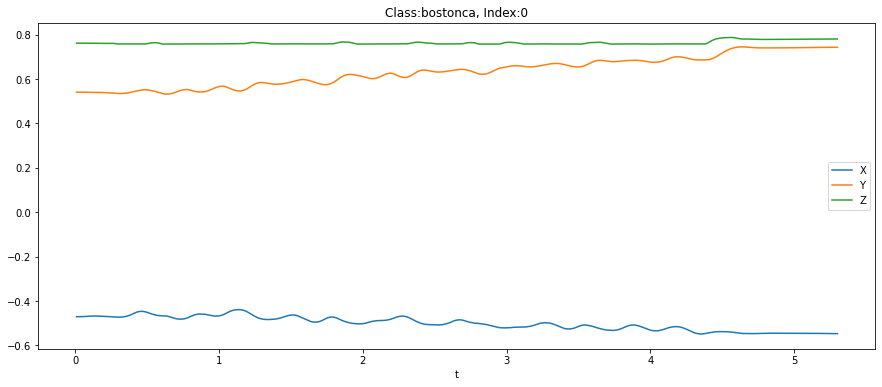

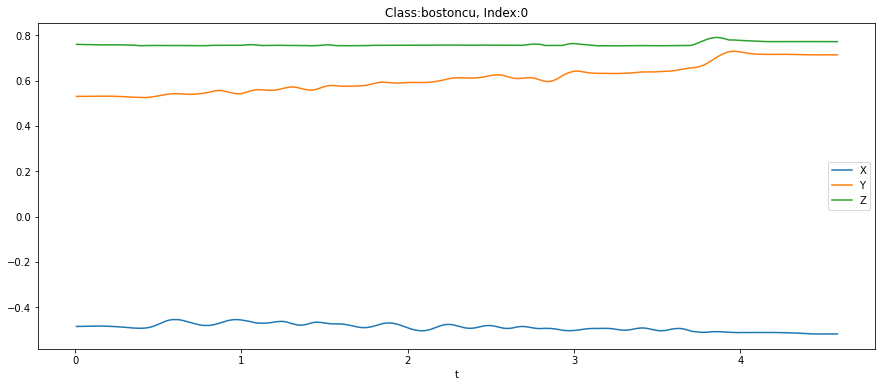

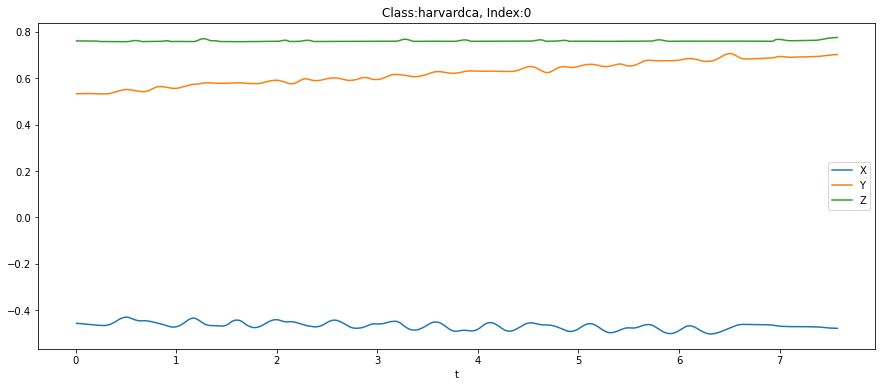

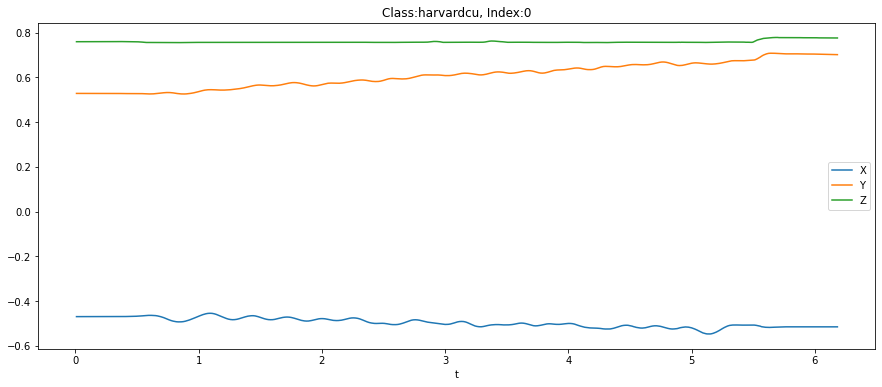

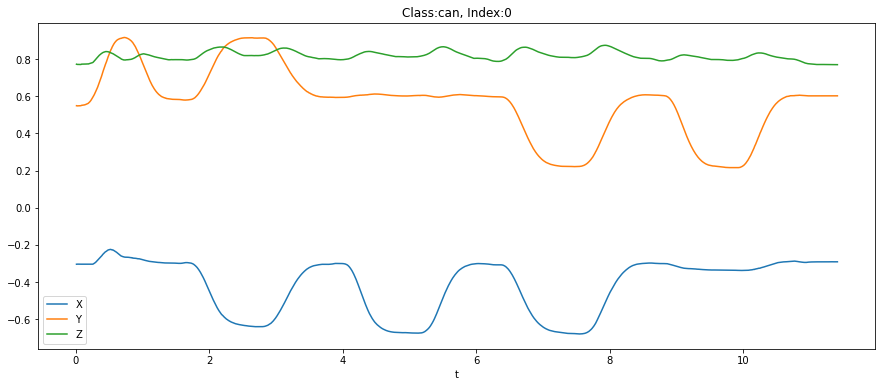

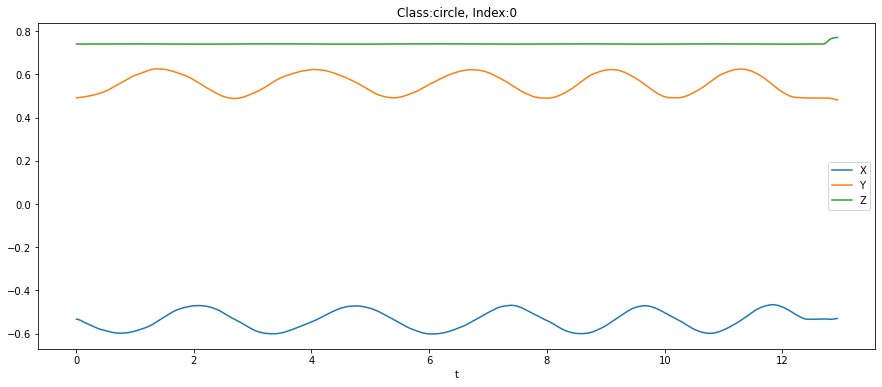

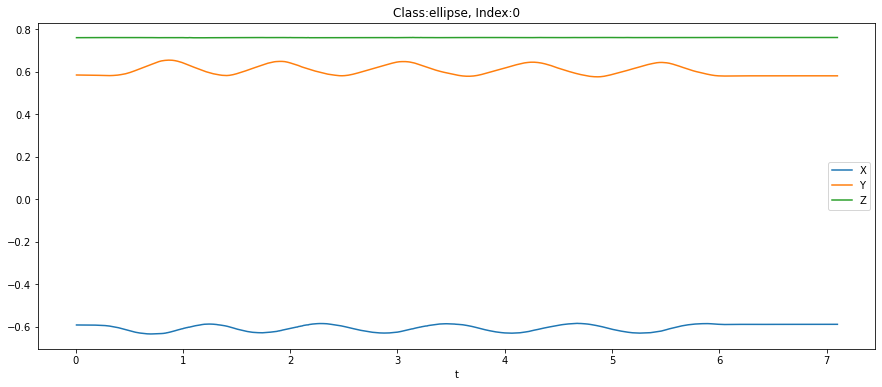

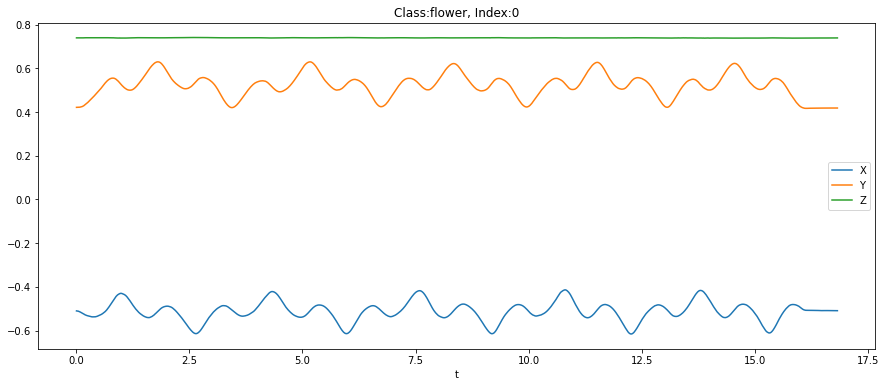

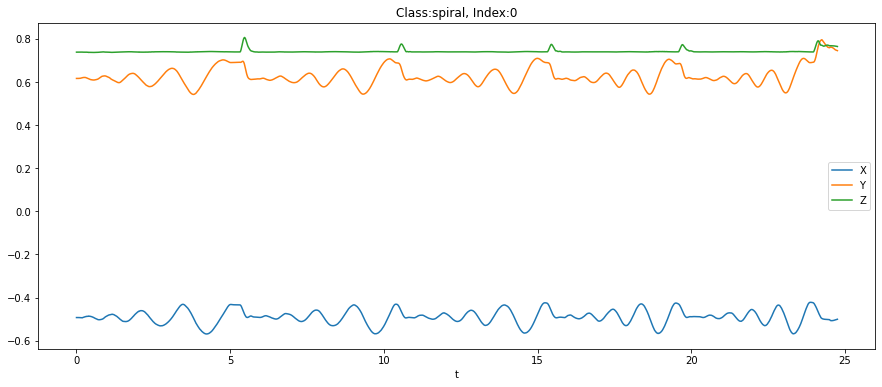

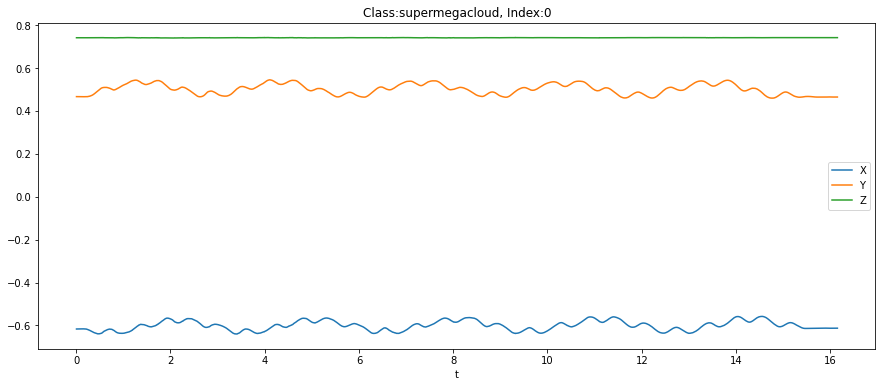

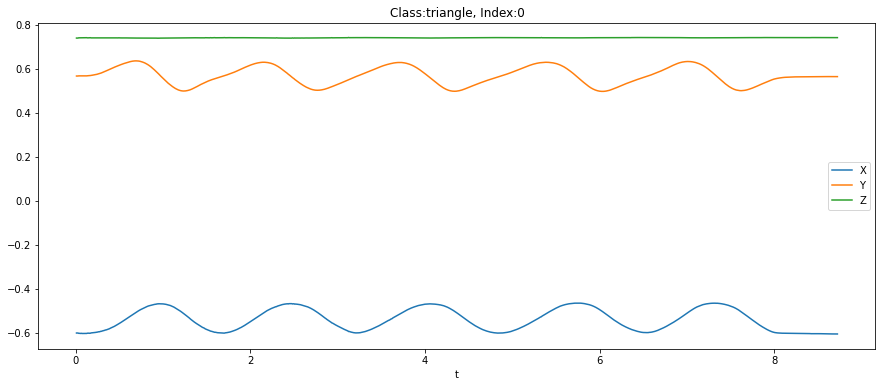

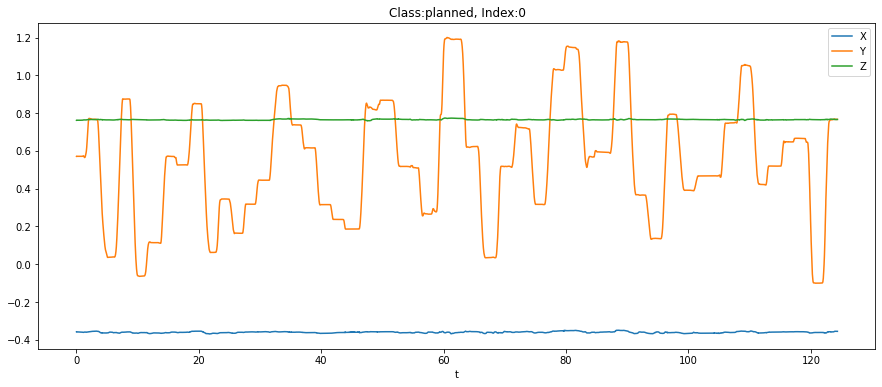

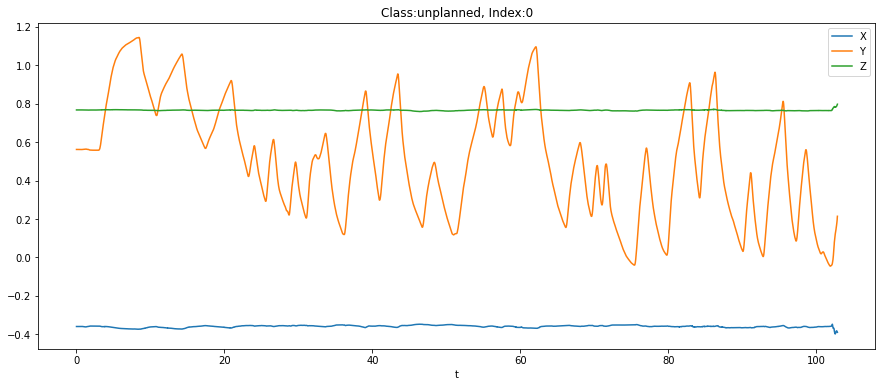

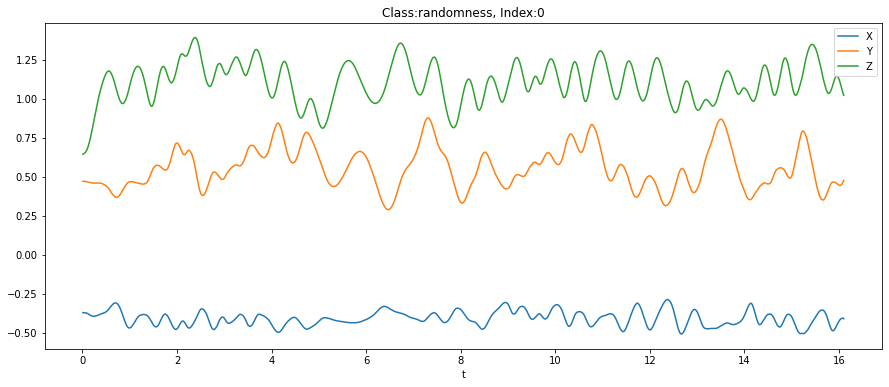

In [81]:
def PlotDataset(classname,index, save=False):
  df = datasets[classname][index]
  title = f'Class:{classname}, Index:{index}'
  ax = df.plot(x="t", y=["X", "Y", "Z"], figsize=(15,6), title=title)
  if(save):
    ax.figure.savefig('Images/'+title)

# PlotDataset('randomess', 0)
# PlotDataset('triangle', 0)
for c in classes_lc:
  PlotDataset(c, 0, True)

#Save Dataset in one csv file
format:
user, t, x, y, z, action

In [3]:
#DO NOT RUN THIS CELL
file = 'ComplexUpper-LimbMovements/dataset.csv'
f = open(file, 'w')
f.write('user, t, X, Y, Z, action\n')
f.close()
for k,v in datasets.items():
  for ds in v:
    ds.to_csv(file,mode='a', index=False, header=False)

NameError: ignored

#Load Dataset

In [80]:
file = 'ComplexUpper-LimbMovements/dataset.csv'
df = pd.read_csv(file)
df.head(10)

,user,t,X,Y,Z,action
0,S011,0.008333,-0.47091,0.54091,0.76174,bostonca
1,S011,0.016667,-0.47085,0.54099,0.76181,bostonca
2,S011,0.025000,-0.47087,0.54108,0.76186,bostonca
3,S011,0.033333,-0.47083,0.54115,0.76188,bostonca
4,S011,0.041667,-0.47075,0.54114,0.76190,bostonca
5,S011,0.050000,-0.47058,0.54111,0.76192,bostonca
6,S011,0.058333,-0.47021,0.54111,0.76196,bostonca
7,S011,0.066667,-0.46996,0.54091,0.76198,bostonca
8,S011,0.075000,-0.46957,0.54078,0.76193,bostonca
9,S011,0.083333,-0.46910,0.54059,0.76184,bostonca


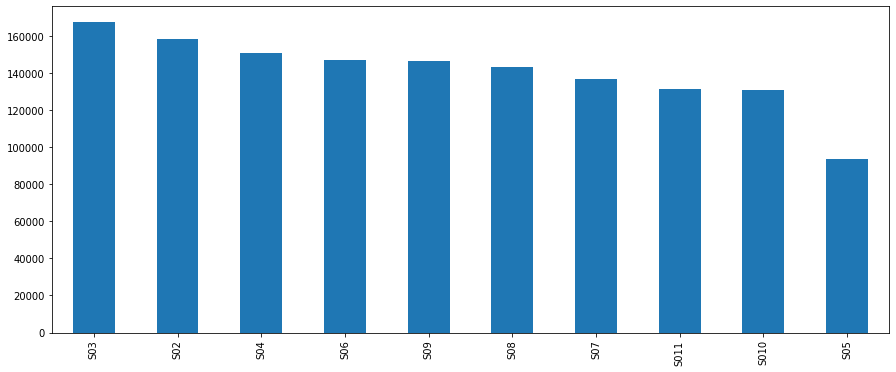

In [10]:
df['user'].value_counts().plot(kind='bar', figsize=(15,6))

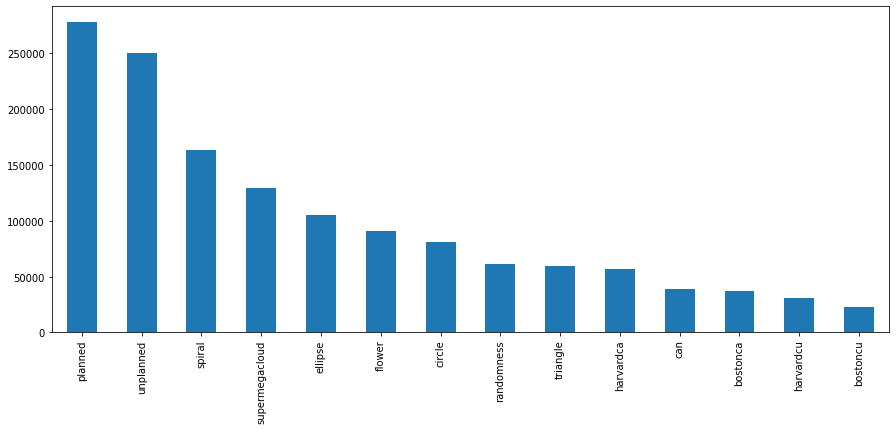

In [9]:
df['action'].value_counts().plot(kind='bar', figsize=(15,6))

In [81]:
df_train = df[(df['user'] != 'S010') & (df['user'] != 'S011')]
df_test = df[(df['user'] == 'S010') | (df['user'] == 'S011')]

print(f'Whole dataset:{len(df)}, Train:{len(df_train)}({(len(df_train)/len(df)):.2f}%), {len(df_test)}({(len(df_test)/len(df)):.2f}%)' )

Whole dataset:1406013, Train:1143580(0.81%), 262433(0.19%)


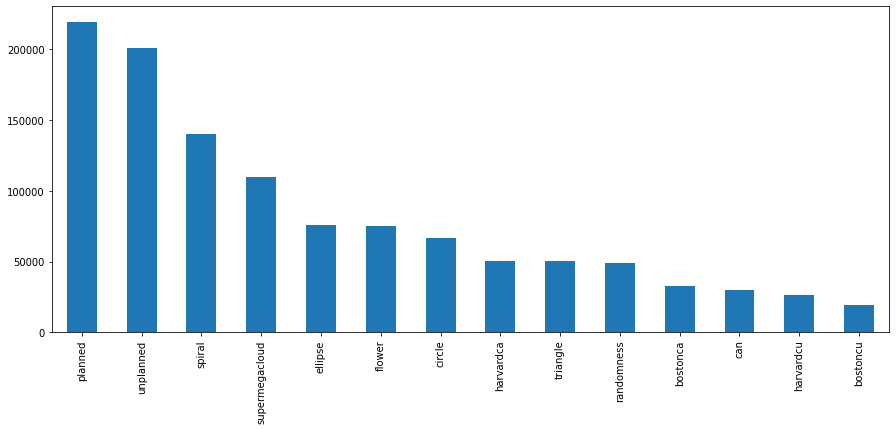

In [22]:
df_train['action'].value_counts().plot(kind='bar', figsize=(15,6))
df_test['action'].value_counts().plot(kind='bar', figsize=(15,6))

#Scale DataFrames

In [64]:
from sklearn.preprocessing import RobustScaler
scale_columns = ['X', 'Y', 'Z']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [4]:
from scipy import stats 
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [83]:
TIME_STEPS = 20
STEP = 40

X_train, y_train = create_dataset(df_train[['X', 'Y', 'Z']], df_train.action, TIME_STEPS, STEP)

X_test, y_test = create_dataset(df_test[['X', 'Y', 'Z']], df_test.action, TIME_STEPS, STEP)
print(X_train.shape, y_train.shape)

(28589, 20, 3) (28589, 1)


In [5]:
train_size = 0.85
val_size = 0.1
TIME_STEPS = 128
STEP = 64

#Total number of entries and flag(total==0)
total = 0
tf_X_train = None
tf_y_train = None
tf_X_test = None
tf_y_test = None
tf_X_val = None
tf_y_val = None
for k,v in datasets.items():
  for ds in v:
    X, y = create_dataset(ds[['X', 'Y', 'Z']], ds.action, TIME_STEPS, STEP)
    #Fixed split
    # train_x_tmp = X[:int(len(X)*train_size)]
    # train_y_tmp = y[:int(len(y)*train_size)]
    # test_x_tmp = X[int(len(X)*train_size):]
    # test_y_tmp = y[int(len(y)*train_size):]

    #Split randomly
    index_train = np.random.choice(len(X),int(len(X)*train_size), replace=False)
    index_test = np.delete(np.arange(len(X)),index_train)
    train_x_tmp = X[index_train]
    train_y_tmp = y[index_train]
    test_x_tmp = X[index_test]
    test_y_tmp = y[index_test]

    index_train = np.random.choice(len(train_x_tmp),int(len(train_x_tmp)*(1-val_size)), replace=False)
    index_val = np.delete(np.arange(len(train_x_tmp)),index_train)
    train_x_tmp = X[index_train]
    train_y_tmp = y[index_train]
    val_x_tmp = X[index_val]
    val_y_tmp = y[index_val]

    tf_train_x_tmp = tf.convert_to_tensor(train_x_tmp)
    tf_train_y_tmp = tf.convert_to_tensor(train_y_tmp)
    tf_test_x_tmp = tf.convert_to_tensor(test_x_tmp)
    tf_test_y_tmp = tf.convert_to_tensor(test_y_tmp)
    tf_val_x_tmp = tf.convert_to_tensor(val_x_tmp)
    tf_val_y_tmp = tf.convert_to_tensor(val_y_tmp)

    if(total==0):
      tf_X_train = tf_train_x_tmp
      tf_y_train = tf_train_y_tmp
      tf_X_test = tf_test_x_tmp
      tf_y_test = tf_test_y_tmp
      tf_X_val = tf_val_x_tmp
      tf_y_val = tf_val_y_tmp
    else:
      tf_X_train = tf.concat([tf_X_train,tf_train_x_tmp],0)
      tf_y_train = tf.concat([tf_y_train,tf_train_y_tmp],0)
      tf_X_test = tf.concat([tf_X_test,tf_test_x_tmp],0)
      tf_y_test = tf.concat([tf_y_test,tf_test_y_tmp],0)
      tf_X_val = tf.concat([tf_X_val,tf_val_x_tmp],0)
      tf_y_val = tf.concat([tf_y_val,tf_val_y_tmp],0)
    total+=len(X)
print(f'Train X:{tf_X_train.shape}, Train y:{tf_y_train.shape}, Test X:{tf_X_test.shape}, Test y:{tf_y_test.shape}, Test X:{tf_X_val.shape}, Test y:{tf_y_val.shape}')
print(f'train/total={(len(tf_X_train)/total):.3f}, test/total={(len(tf_X_test)/total):.3f}, val/train={(len(tf_X_val)/len(tf_X_train)):.3f}')

Train X:(15823, 128, 3), Train y:(15823, 1), Test X:(3421, 128, 3), Test y:(3421, 1), Test X:(1993, 128, 3), Test y:(1993, 1)
train/total=0.745, test/total=0.161, val/train=0.126


#One Hot Encoding

In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

# enc = enc.fit(y_train)
# y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

X_train = tf_X_train
X_test = tf_X_test
X_val = tf_X_val

enc = enc.fit(tf_y_train)
y_train = enc.transform(tf_y_train)
y_test = enc.transform(tf_y_test)
y_val = enc.transform(tf_y_val)

#Bidirectional LSTM

In [10]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=256,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

#LSTM

In [51]:
print(X_train.shape[1], X_train.shape[2])
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

128 3


#Conv + LSTM

In [105]:
n_steps, n_length = 4, 32
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, n_length, tf_X_train.shape[2])), axis=[0])
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, n_length, tf_X_test.shape[2])), axis=[0])
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, n_length, tf_X_val.shape[2])), axis=[0])

model = keras.Sequential()
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,tf_X_train.shape[-1])))
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.5)))
model.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(pool_size=2)))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

#Conv LSTM

In [98]:
n_steps, n_length = 4, 32
X_train = tf.squeeze(tf.reshape(tf_X_train, (-1, tf_X_train.shape[0], n_steps, 1, n_length, tf_X_train.shape[2])))
X_test = tf.squeeze(tf.reshape(tf_X_test, (-1, tf_X_test.shape[0], n_steps, 1, n_length, tf_X_test.shape[2])))
X_val = tf.squeeze(tf.reshape(tf_X_val, (-1, tf_X_val.shape[0], n_steps, 1, n_length, tf_X_val.shape[2])))

# define model
model = keras.Sequential()
model.add(keras.layers.ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, tf_X_train.shape[-1])))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

In [8]:
callbacks = []
checkpoint_path = 'KSckp/'
monitor = 'acc'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  save_weights_only=True,
  monitor=monitor,
  mode='max',
  save_best_only=True)
callbacks.append(model_checkpoint_callback)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor=monitor, min_delta=0, patience=4, verbose=1, mode='auto',
  baseline=None, restore_best_weights=True)
#self.callbacks.append(self.early_stopping)

In [ ]:
print(X_train.shape, X_val.shape)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(
    X_train, y_train,
    epochs=2,
    batch_size=32,
    validation_data=(X_val,y_val),
    shuffle=True,
    callbacks=callbacks
)

(15823, 128, 3) (1993, 128, 3)
Epoch 1/2
239/495 [=============>................] - ETA: 3:00 - loss: 2.3323 - acc: 0.2120

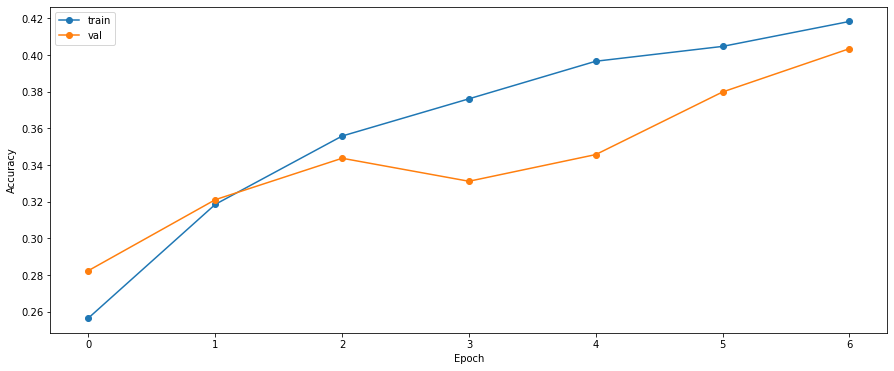

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(history.history['acc'], label='train', marker='o')
plt.plot(history.history['val_acc'], label='val', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [232]:
model.evaluate(X_test, y_test)

665/665 [==============================] - 4s 6ms/step - loss: 11.2092 - acc: 0.1765


[11.209168434143066, 0.17648719251155853]

In [159]:
y_pred = model.predict(X_test)
# y_pred = tf.one_hot(tf.argmax(y_pred, axis=1), depth=y_pred.shape[1])

In [164]:
y_pred.shape

(35352, 14)

In [208]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
  # print(type(y_true),y_true.shape,y_true[:10] ,type(y_pred),y_pred.shape,y_pred[:10])
  y_test_non_category = [ np.argmax(t) for t in y_test ]
  y_predict_non_category = [ np.argmax(t) for t in y_pred ]

  cm = confusion_matrix(y_test_non_category, y_predict_non_category)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

<class 'numpy.ndarray'> (35352, 14) [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] <class 'tensorflow.python.framework.ops.EagerTensor'> (35352, 14) tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

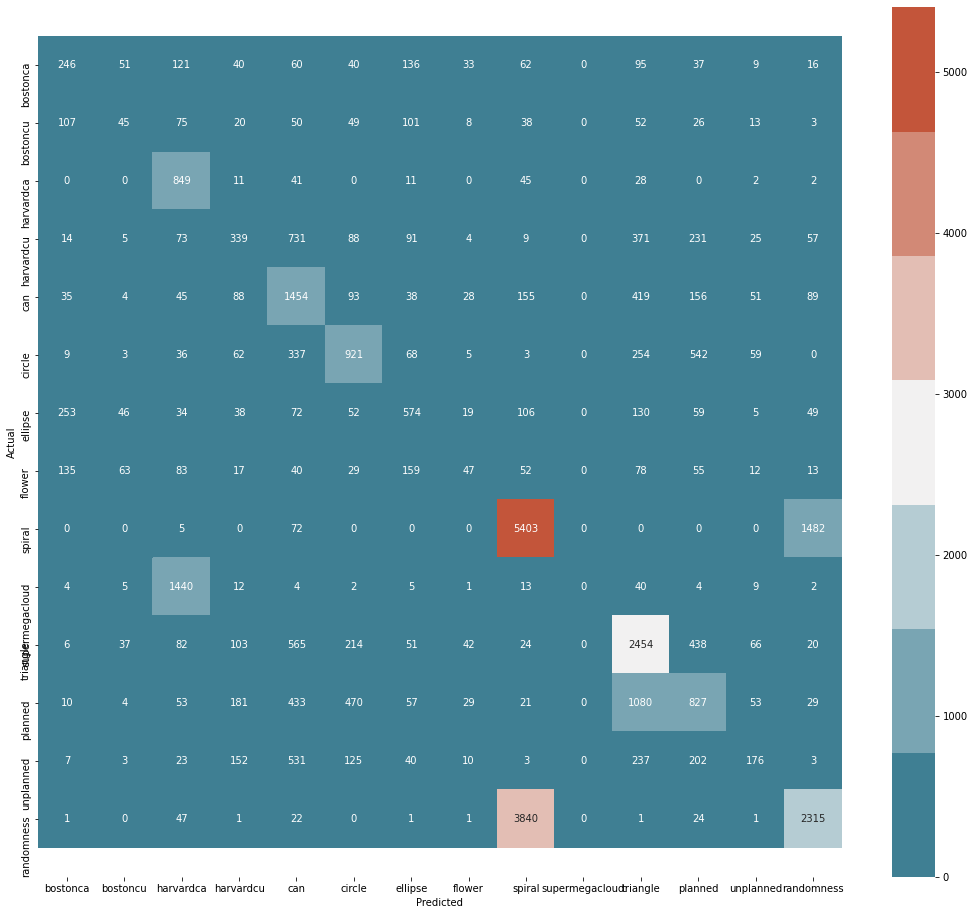

In [209]:
plot_cm(y_test,y_pred,classes_lc)